# Reinforcement Learning

# 2. Dynamic programming

This notebook presents policy iteration and value iteration for finding the optimal policy.

Note that these techniques require the enumeration of all states and thus apply to a few models only (e.g., walk, maze, Tic-Tac-Toe, Nim).


In [1]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [2]:
import numpy as np

In [3]:
from lib.model import Walk, Maze, TicTacToe, Nim, ConnectFour
from lib.agent import Agent

## Walk:


In [4]:
walk = Walk()
states = walk.get_all_states()
len(states)

25

## Maze:


In [5]:
maze_map = np.load("../lib/maze.npy")

In [6]:
maze = Maze()
init_state = (1, 0)
exit_state = (1, 20)
maze.set_parameters(maze_map, init_state, [exit_state])
maze = Maze()

In [7]:
states = maze.get_all_states()
len(states)

105

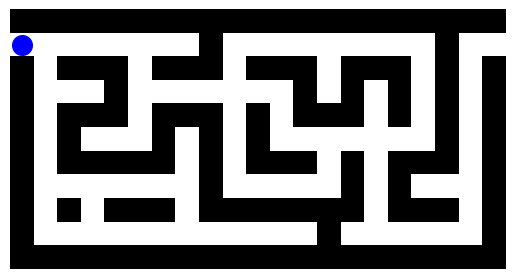

In [8]:
maze.display()

## Policy Iteration:


In policy iteration, you start from an arbitrary policy and improve it sequentially from its value function. The limiting policy is optimal.


In [9]:
from lib.dynamic import PolicyEvaluation, PolicyIteration

In [10]:
# let's start with the random policy
agent = Agent(maze)
policy = agent.policy

In [11]:
# policy evaluation
algo = PolicyEvaluation(maze, policy)
algo.evaluate_policy()
values = algo.values
len(values)

105

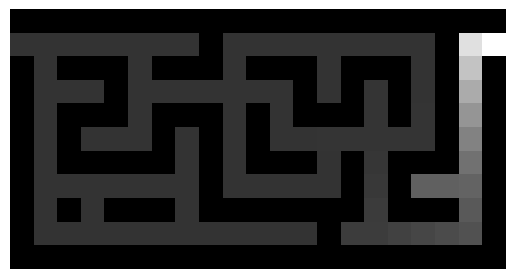

In [12]:
maze.display_values(values)

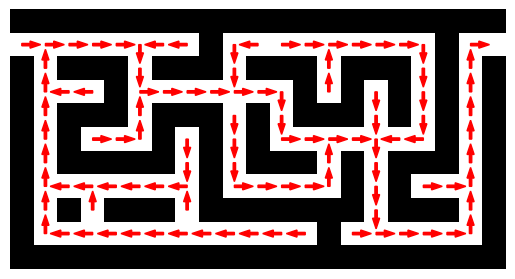

In [13]:
# policy improvement
new_policy = algo.get_policy()
maze.display_policy(new_policy)

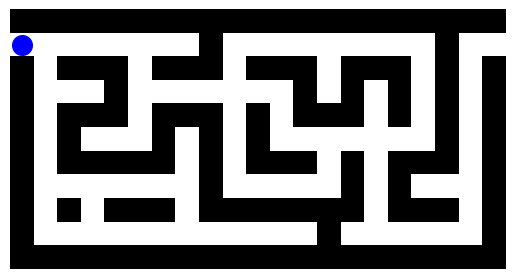

In [14]:
# let's test this new policy
agent = Agent(maze, new_policy)
stop, states, rewards = agent.get_episode()
animation = maze.display(states)

In [15]:
animation

In general, several iterations of policy evaluation / policy improvement are necessary.


In [16]:
algo = PolicyIteration(maze)

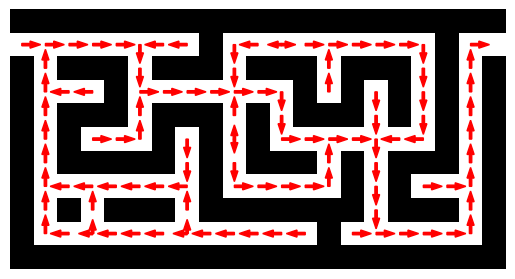

In [17]:
policy = algo.get_optimal_policy()
maze.display_policy(policy)

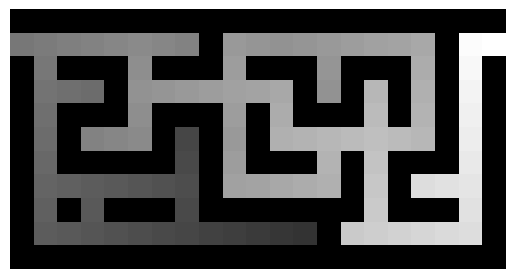

In [18]:
values = algo.values
maze.display_values(values)

## To do:


Consider the Walk environment with a discount factor $\gamma = 0.9$.

- What is the expected gain of a random walk?
- Compare with the expected gain of the optimal policy, obtained by Policy Iteration.
- Display the optimal value function and the optimal policy. Interpret the results.
- Increase the strength of the wind and observe the new results.


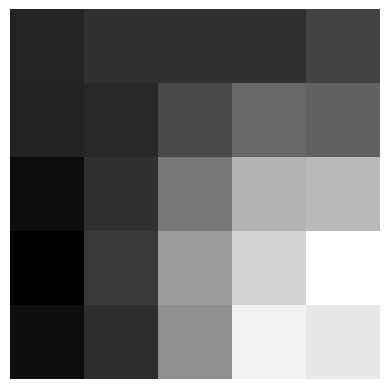

In [19]:
# set the default wind parameters
# needed for multiple runs without reinitializing the environment
Walk.set_parameters(Walk.Size, Walk.Rewards, {(0, 1): 0.1, (1, 0): 0.2})
walk = Walk()

# random policy
agent = Agent(walk)

# display the random policy values
random_policy = agent.policy
algo = PolicyEvaluation(walk, random_policy)
algo.evaluate_policy()
walk.display_values(algo.values)

### What is the expected gain of a random walk?


In [20]:
gamma = 0.9
gains = agent.get_gains(gamma=gamma)
print(f"Expected gain of the random walk: {np.mean(gains)}")

Expected gain of the random walk: 1.7045186735588211


### Compare with the expected gain of the optimal policy, obtained by Policy Iteration:


In [21]:
algo = PolicyIteration(walk, gamma=gamma)
opt_policy = algo.get_optimal_policy()

agent = Agent(walk, opt_policy)
new_gains = agent.get_gains(gamma=gamma)

print(f"Expected gain of optimal policy: {np.mean(new_gains)}")

Expected gain of optimal policy: 9.82313136734689


In [22]:
print(f"Gain difference: {np.mean(new_gains) - np.mean(gains)}")

Gain difference: 8.11861269378807


### Display the optimal value function and the optimal policy. Interpret the results:


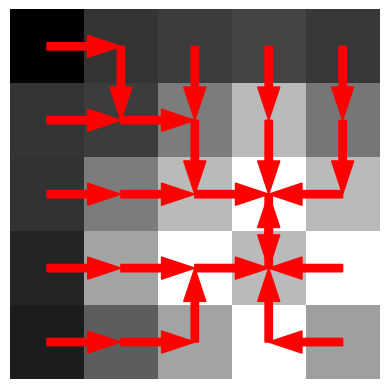

In [23]:
walk.display_policy(opt_policy)
walk.display_values(algo.values)

In [24]:
walk.Rewards

{(1, 1): 1, (1, 3): -1, (3, 1): -1, (3, 3): 3}

As we can see the gain difference between the random walk and the optimal policy is positive, which means that the optimal policy is better than the random walk.

We can see this by also observing the display of the value function. The white cells (representing the highest values) are located near the largest rewards located in the cell (3,3).


### Increase the strength of the wind and observe the new results:


In [25]:
# previous wind
wind = walk.Wind

In [26]:
# new wind
wind_ = {(0, 1): 0.8, (1, 0): 0.1}

In [27]:
Walk.set_parameters(Walk.Size, Walk.Rewards, wind_)
wind_walk = Walk()

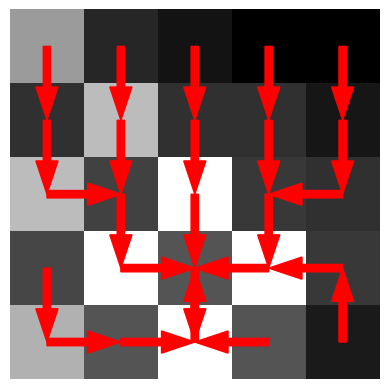

In [28]:
wind_algo = PolicyIteration(wind_walk, gamma=gamma)
wind_opt_policy = wind_algo.get_optimal_policy()

walk.display_policy(wind_opt_policy)
walk.display_values(wind_algo.values)

In [29]:
wind_agent = Agent(wind_walk, wind_opt_policy)
wind_gains = wind_agent.get_gains(gamma=gamma)

print(f"Expected gain of optimal policy with wind: {np.mean(wind_gains)}")

Expected gain of optimal policy with wind: 14.28632600337226


In this new setting the wind pushes the agent more to the right with a high probability.

We can thus see that the optimal policy converges in the cell to the left of the largest reward (which is positioned in 3,3). The value function is higher in the cells adjacent to the new cell targeted by the optimal policy.


## Value Iteration:

Value iteration relies on Bellman's optimality equation.


## To do:

Check the code of `ValueIteration` below.

- Complete the method `get_optimal_policy`.
- Test it on the maze and the walk.
- You play TicTacToe at random against an adversary using the one-step policy. What is your expected gain?
- Observe the improvement when you play perfectly against the same adversary.
- Do the same with Nim.


In [30]:
class ValueIteration(PolicyEvaluation):
    """Value iteration.

    Parameters
    ----------
    model: object of class Environment
        The model.
    player: int
        Player for games (1 or -1, default = default player of the game).
    gamma: float
        Discount factor (between 0 and 1).
    n_iter: int
        Maximum number of value iterations.
    """

    def __init__(self, model, player=None, gamma=1, n_iter=100):
        agent = Agent(model, player=player)
        policy = agent.policy
        player = agent.player
        super(ValueIteration, self).__init__(model, policy, player, gamma)
        self.n_iter = n_iter

    def get_optimal_policy(self):
        """Get the optimal policy by iteration of Bellman's optimality equation."""
        # Bellman's optimality equation
        values = np.zeros(self.n_states)
        for _ in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {
                action: transition.dot(next_values)
                for action, transition in self.transitions.items()
            }
            values = np.zeros(self.n_states)
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    actions = self.get_actions(state)
                    # update values
                    if self.player == 1:
                        values[i] = max([action_value[action][i] for action in actions])
                    else:
                        values[i] = min([action_value[action][i] for action in actions])
        self.values = values
        policy = self.get_policy()
        return policy

### Test on maze:


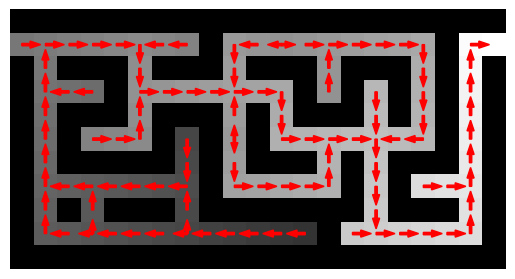

In [31]:
algo = ValueIteration(maze)

opt_policy = algo.get_optimal_policy()
maze.display_policy(opt_policy)

values = algo.values
maze.display_values(values)

### Test on walk:


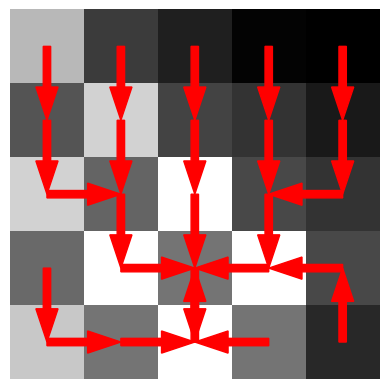

In [32]:
algo = ValueIteration(walk)

opt_policy = algo.get_optimal_policy()
walk.display_policy(opt_policy)

values = algo.values
walk.display_values(values)

### Expected gain playing TicTacToe at random against an adversary using the one-step policy:


In [33]:
game = TicTacToe(adversary_policy="one_step")
agent = Agent(game)

In [34]:
gains = agent.get_gains()
print(
    "Expected gain playing randomly against the adversary one step ahead:",
    np.mean(gains),
)

Expected gain playing randomly against the adversary one step ahead: -0.62


We are getting a negative value. This means that, on average, we are losing.

This is expected since the adversary is playing seeing one step ahead and we are playing randomly.


### Playing perfectly against the same adversary:


In [35]:
algo = ValueIteration(game)
opt_policy = algo.get_optimal_policy()
agent = Agent(game, policy=opt_policy)

In [36]:
gains = agent.get_gains()
print(
    f"Expected gain playing optimally against the adversary one step ahead: {np.mean(gains)}"
)

Expected gain playing optimally against the adversary one step ahead: 0.95


Now the expected gain is positive. This means that, on average, we are winning.

This is expected since we are playing perfectly.


### Playing randomly Nim against an adversary that is using the one-step policy:


In [37]:
game = Nim(adversary_policy="one_step")
agent = Agent(game)

In [38]:
gains = agent.get_gains()
print(
    "Expected gain playing randomly against the adversary one step ahead:",
    np.mean(gains),
)

Expected gain playing randomly against the adversary one step ahead: 0.08


In this setting we are getting an expected gain close to zero. This means that, on average, we are not winning nor losing.

It seems like seeing one step ahead is not enough for our opponent to consistently win in Nim.


### Playing Nim perfectly against the same adversary:


In [39]:
algo = ValueIteration(game)
opt_policy = algo.get_optimal_policy()
agent = Agent(game, policy=opt_policy)

In [40]:
gains = agent.get_gains()
print(
    f"Expected gain playing optimally against the adversary one step ahead: {np.mean(gains)}"
)

Expected gain playing optimally against the adversary one step ahead: 1.0


Now we get an expected gain of 1. This means that we are always winning.


## Perfect players:


We now use Value Iteration to get perfect players, assuming the best response of the adversary.


## To do:

Check the code of the new class `ValueIteration` below.

- Complete the method `get_perfect_players`.
- Test it on TicTacToe. Who wins?
- Test it on Nim. Who wins?
- Is this approach applicable to ConnectFour? Why?


In [41]:
from scipy import sparse

In [42]:
class ValueIteration(PolicyEvaluation):
    """Value iteration.

    Parameters
    ----------
    model: object of class Environment
        The model.
    player: int
        Player for games (1 or -1, default = default player of the game).
    gamma: float
        Discount factor (between 0 and 1).
    n_iter: int
        Maximum number of value iterations.
    """

    def __init__(self, model, player=None, gamma=1, n_iter=100):
        agent = Agent(model, player=player)
        policy = agent.policy
        player = agent.player
        super(ValueIteration, self).__init__(model, policy, player, gamma)
        self.n_iter = n_iter

    def get_perfect_players(self):
        """Get perfect players for games, with the best response of the adversary."""
        if not self.model.is_game():
            raise ValueError("This method applies to games only.")
        # get transitions for each player
        actions = self.model.get_all_actions()
        transitions = {
            action: sparse.lil_matrix((self.n_states, self.n_states))
            for action in actions
        }
        for i, state in enumerate(self.states):
            actions = self.model.get_available_actions(state)
            for action in actions:
                next_state = self.model.get_next_state(state, action)
                j = self.get_state_id(next_state)
                transitions[action][i, j] = 1
        transitions = {
            action: sparse.csr_matrix(transition)
            for action, transition in transitions.items()
        }
        self.transitions = transitions
        # Bellman's optimality equation
        values = np.zeros(self.n_states)
        for _ in range(self.n_iter):
            next_values = self.rewards + self.gamma * values
            action_value = {
                action: transition.dot(next_values)
                for action, transition in transitions.items()
            }
            values = np.zeros(self.n_states)
            for i, state in enumerate(self.states):
                if not self.model.is_terminal(state):
                    player, _ = state
                    actions = self.model.get_available_actions(state)
                    if player == 1:
                        values[i] = max([action_value[action][i] for action in actions])
                    else:
                        values[i] = min([action_value[action][i] for action in actions])
        self.values = values
        # policies
        policy = self.get_policy(self.player)
        adversary_policy = self.get_policy(-self.player)
        return policy, adversary_policy

### Playing TicTacToe


In [43]:
game = TicTacToe()

algo = ValueIteration(game)
policy, adversary_policy = algo.get_perfect_players()

# set the optimal policies
game = TicTacToe(adversary_policy=adversary_policy)
agent = Agent(game, policy=policy)

gains = agent.get_gains()
print(f"Expected gain playing optimally against a perfect adversary: {np.mean(gains)}")

n_games = 100
results = {"win": 0, "tie": 0, "loss": 0}
for _ in range(n_games):
    _, _, rewards = agent.get_episode()
    if rewards[-1] == 1:
        results["win"] += 1
    elif rewards[-1] == 0:
        results["tie"] += 1
    else:
        results["loss"] += 1

print(f"\nResults of {n_games} episodes:")
print(results)

Expected gain playing optimally against a perfect adversary: 0.0

Results of 100 episodes:
{'win': 0, 'tie': 100, 'loss': 0}


The expected gain is zero. This means that the game is on average a draw.


### Playing Nim


In [44]:
game = Nim()

algo = ValueIteration(game)
policy, adversary_policy = algo.get_perfect_players()

# set the optimal policies
game = Nim(adversary_policy=adversary_policy)
agent = Agent(game, policy=policy)

gains = agent.get_gains()
print(f"Expected gain playing optimally against a perfect adversary: {np.mean(gains)}")

n_games = 100
results = {"win": 0, "tie": 0, "loss": 0}

for _ in range(n_games):
    _, _, rewards = agent.get_episode()
    if rewards[-1] == 1:
        results["win"] += 1
    elif rewards[-1] == 0:
        results["tie"] += 1
    else:
        results["loss"] += 1

print(f"\nResults of {n_games} episodes:")
print(results)

Expected gain playing optimally against a perfect adversary: -1.0

Results of 100 episodes:
{'win': 0, 'tie': 0, 'loss': 100}


Also in this case the expected gain is negative. We are losing on average.


### Playing ConnectFour


In [45]:
try:
    game = ConnectFour()
    algo = ValueIteration(game)
except ValueError as e:
    print(e)

Not applicable. The state space is too large.


We cannot apply this approach to ConnectFour since the state space is too large to be enumerated.
